In [1]:
import wandb
from collections import deque
import torch
import numpy as np


In [2]:
try:
    key = key or input()
except NameError:
    key = input('type your wandb api key: ')

In [3]:
wandb.login(key=key)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: felissi. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\user/.netrc


True

In [4]:
wandb.init(project="my-awesome-project")

In [5]:
from Agent import Agent
from Board import Board

In [6]:
BUFFER_SIZE         = int(1e4)
BATCH_SIZE          = 64
GAMMA               = 0.90  # discount factor
TAU                 = 1e-3  # soft update of target parameter
LEARNING_RATE       = 1e-3
UPDATE_EVERY        = 10    # how often to update the local
TARGET_UPDATE_EVERY = 50    # how often to update the target
STATE_SIZE          = 16
ACTION_SIZE         = 4   

In [7]:
agent = Agent(STATE_SIZE, ACTION_SIZE, LEARNING_RATE, BUFFER_SIZE, BATCH_SIZE)
env = Board()


In [8]:
wandb.watch(agent.qnetwork_local,log_freq=10)

[]

## Monitoring metrics and parameters

### Metrics for how the model doing and updating
1. q values
1. gradients
1. loss
1. eps
1. 


### Metrics for model's performance
1. largest number of the board
1. accumulate reward
1. number of rounds

In [9]:
def train(agent: Agent, n_episodes, max_time_step, eps_start, eps_end, eps_decay):
    scores = []
    num_rounds = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for episode in range(n_episodes):
        env.reset()
        state = env.board
        accumulate_reward = 0
        rounds = 0
        for time_step in range(max_time_step):
            action_values = agent.q_value(state, eps)
            action = agent.decide(action_values, eps)
            next_state, reward, done = env.step(action)
            agent.step(state, action, reward, next_state, done)
            """ === this step has finished === """
            wandb.log({'action':action, 'reward': reward, 'eps': eps})
            wandb.log({f'action_values[{i}]':q for i, q in enumerate(action_values.cpu().numpy().flatten()) })
            if agent.time_step % UPDATE_EVERY == 0 and len(agent.memory) > BATCH_SIZE:
                loss = agent.learn_from_experience()
                wandb.log({'loss':loss})
            if agent.time_step % TARGET_UPDATE_EVERY == 0:
                agent.soft_update()
            """ === next iteration === """
            state = next_state
            accumulate_reward += reward
            rounds += 1
            if done:
                wandb.log({'rounds':rounds,'accumulate_reward':accumulate_reward, 'max_number':np.max(state)})
                break
        scores_window.append(accumulate_reward)
        scores.append(accumulate_reward)
        num_rounds.append(rounds)
        eps = max(eps_end, eps-eps_decay)
        if episode % 100 == 0:
            print(episode, np.mean(scores_window))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pt')
    return scores, num_rounds

In [10]:
train(agent, n_episodes=1000, max_time_step=1000, eps_start=1.0, eps_end=0.05, eps_decay=0.01)

0 970.0
100 1766.4
200 1761.3
300 1710.6
400 1733.2
500 1736.6
600 1738.3
700 1751.0
800 1782.7
900 1777.2


([970,
  1810,
  2470,
  2320,
  1970,
  1770,
  1510,
  1740,
  1430,
  1370,
  2190,
  2070,
  1440,
  1090,
  1480,
  2010,
  2060,
  1530,
  1730,
  2010,
  2540,
  1580,
  1690,
  1540,
  1500,
  1860,
  1390,
  1610,
  2100,
  2120,
  2070,
  1720,
  1360,
  2550,
  1770,
  1490,
  1280,
  2170,
  2180,
  2440,
  1930,
  1560,
  2290,
  1230,
  1850,
  1940,
  2350,
  2050,
  2100,
  2260,
  2280,
  1260,
  1690,
  1560,
  1560,
  2280,
  1650,
  1560,
  1880,
  2160,
  1320,
  1600,
  1240,
  1660,
  1660,
  1730,
  2220,
  1650,
  1850,
  1350,
  1440,
  1180,
  1840,
  1610,
  1460,
  1760,
  1610,
  1530,
  1740,
  2080,
  1780,
  1760,
  1320,
  1870,
  1990,
  2160,
  1430,
  2000,
  1370,
  1610,
  1710,
  1670,
  1780,
  1670,
  1680,
  1600,
  1390,
  1500,
  1960,
  1730,
  1730,
  1430,
  1590,
  1840,
  1050,
  2070,
  1780,
  1630,
  1790,
  1650,
  1740,
  1760,
  1600,
  1390,
  2040,
  1720,
  1930,
  1680,
  2070,
  1970,
  1620,
  1690,
  1410,
  1830,
  1780,
 

In [11]:
agent.q_value(np.array([[0,0,2,0],[0,0,2,0],[0,0,2,0],[0,0,2,0]])).cpu().numpy().flatten()

array([55.843666, 56.95682 , 55.72124 , 58.17358 ], dtype=float32)

In [12]:
agent.act(np.array([[0,0,2,0],[0,0,2,0],[0,0,2,0],[0,0,2,0]]), eps=0)

3

In [15]:
def sample(n:int=1000, valid=True):
    round_counts:list[int] = []
    rewards: list[int] = []
    max_num: list[int] = []
    env = Board()
    for epoch in range(n):
        env.reset()
        state = env.board
        done = False
        count = 0
        while not done:
            action = agent.act(state)
            # if valid:
            #     while not b.squeezable(b.choice_to_direction(action)):
            #         action = random.choice([0,1,2,3])

            board, reward, done = env.step(action)
            rewards.append(reward)
            count += 1
            if done:
                max_num.append(np.max(board))
        round_counts.append(count)
    return round_counts, rewards, max_num
    

In [17]:
round_counts, rewards, max_num = sample(100)

(array([ 3., 41., 49.,  0.,  0.,  0.,  4.,  0.,  0.,  3.]),
 array([ 58. ,  69.9,  81.8,  93.7, 105.6, 117.5, 129.4, 141.3, 153.2,
        165.1, 177. ]),
 <BarContainer object of 10 artists>)

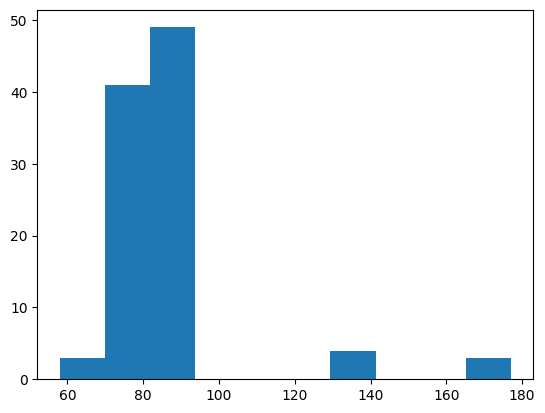

In [21]:
import matplotlib.pyplot as plt
plt.hist(round_counts)